In [1]:
#Imports for python 2 compatibility
from __future__ import absolute_import, division, print_function
__metaclass__ = type

#Imports for M-LOOP
import mloop.interfaces as mli
import mloop.controllers as mlc
import mloop.visualizations as mlv

#Other imports
import numpy as np
import time
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Declare your custom class that inherets from the Interface class
class CustomInterface(mli.Interface):
    
    #Initialization of the interface, including this method is optional
    def __init__(self):
        #You must include the super command to call the parent class, Interface, constructor 
        super(CustomInterface,self).__init__()
        self.l=400  # mm
        self.r=75   # mm 
        
    
    def get_next_cost_dict(self,params_dict):
        
        #Get parameters from the provided dictionary
        params = params_dict['params']
        
        cost=cal_grad(params=params,l=self.l,r=self.r,show_plot=False)

        uncer = 0
        #The evaluation will always be a success
        
        bad = False
        
        cost_dict = {'cost':cost, 'uncer':uncer, 'bad':bad}
        return cost_dict

'''
def cal_grad(params,l,r,show_plot=True):
        #n=20
        u=4*np.pi*1e-7
        N=1
        I=1

        params=np.round(params,decimals=3)
        inv_para=l/1000-params[-1::-1]
        z=np.concatenate([params,inv_para])
        z_list=z.tolist()
        z_list.sort()
        print('z is:',z_list)
        res=[]
        x=[]
        for s in range(0,int(np.ceil(l))+1):
            s/=1000
            x.append(s)
            d=np.square(z-s)
            b=np.sum(u*r**2*N/(2*np.power(r**2+d,1.5)))*I
            res.append(b)
        r_central=r/2                    # mm
        low=int(np.floor(l/2-r_central))
        up=int(np.ceil(l/2+r_central))
        array=res[low:up+1]
        dy=np.max(array)-np.min(array)
        #dx=(index_1-index_2)/100
        grad=dy*7e9
        rel_err=dy/np.max(array)
        print('grad and rel_err are:',grad,rel_err)

        if show_plot:
            plt.figure(figsize=(16,9))
            plt.title('B-Z',fontsize=24)
            plt.xlabel('Z',fontsize=20)
            plt.ylabel('B',fontsize=20)
            plt.plot(x,res,c='darkviolet')
            plt.show()

        return 10*np.log10(rel_err)
''' 

def cal_grad(params,l,r,show_plot=True):
    params=np.round(params,decimals=2)
    x=np.mat(np.arange(-int(np.ceil(l/2)),int(np.ceil(l/2))+1)/1000).T
    z=(np.concatenate([-params,params])+0)/1000
    z_list = z.tolist()
    z_list.sort()
    print('z is:',z_list)
    z=np.mat(z)
    
    d=np.square(x-z)
    r=r/1000
    u=4*np.pi*1e-7
    N=1
    I=1
    B=u*r**2*N*I/(2*np.power(r**2+d,1.5))
    res=np.squeeze(np.array(np.sum(B,axis=1)))
    #r_central=r/2*1000                    # mm
    r_central=50                           # mm
    low=int(np.floor(l/2-r_central/2))
    up=int(np.ceil(l/2+r_central/2))
    #print('low and up are:',low,up)
    array=res[low:up+1]
    dy=np.max(array)-np.min(array)
    #dx=(index_1-index_2)/100
    grad=dy*7e9
    rel_err=dy/np.max(array)
    print('grad, rel_err and B are:',grad,rel_err,np.max(array))
    if show_plot:
        plt.figure(figsize=(16,9))
        plt.title('B-Z',fontsize=24)
        plt.xlabel('Z',fontsize=20)
        plt.ylabel('B',fontsize=20)
        plt.plot(x,res,c='darkviolet')

    return 10*np.log10(rel_err)

def main():
    #M-LOOP can be run with three commands
    
    #First create your interface
    interface = CustomInterface()
    #Next create the controller. Provide it with your interface and any options you want to set
    n=10
    d=25
    '''
    para=np.linspace(0,interface.l/2-r,n+1)
    low=para[0:n]
    up=para[1:n+1]
    '''
    low=np.array([0]*n)
    up=np.array([interface.l/2-d/2]*n)
    '''
    #z=np.array([0.003, 0.009, 0.009, 0.009, 0.019, 0.021, 0.032, 0.038, 0.043, 0.061, 0.078, 0.079, 0.1, 0.103, 0.103])
    z=np.array([0.0, 0.008, 0.019, 0.034, 0.035, 0.042, 0.063, 0.089, 0.099, 0.099])
    half=0.03
    low=z-half
    low=np.maximum(0,low)
    up=z+half
    up=np.minimum(interface.l/200-r,up)
    '''
    controller = mlc.create_controller(interface, 
                                       #training_type='random',
                                       controller_type='neural_net',
                                       max_num_runs = 2000,
                                       #target_cost = 0,
                                       num_params = n, 
                                       min_boundary = low.tolist(),
                                       max_boundary = up.tolist(),
                                       keep_prob=0.8)
    #To run M-LOOP and find the optimal parameters just use the controller method optimize
    controller.optimize()
    
    #The results of the optimization will be saved to files and can also be accessed as attributes of the controller.
    print('Best parameters found:')
    print(controller.best_params)
    
    #You can also run the default sets of visualizations for the controller with one command
    mlv.show_all_default_visualizations(controller,max_parameters_per_plot=2)
    '''
    mlv.create_neural_net_learner_visualizations(controller.ml_learner.total_archive_filename, 
                                                file_type=controller.ml_learner.learner_archive_file_type,
                                                plot_cross_sections=True)
    plt.show()
    '''
    cal_grad(params=controller.best_params,l=interface.l,r=interface.r)
    cal_grad(params=controller.predicted_best_parameters,l=interface.l,r=interface.r)
    

In [3]:
%%timeit
#Ensures main is run when this code is run as a script
main()

UsageError: Line magic function `%%timeit` not found.


In [5]:
from sklearn import linear_model
def linear_regre_1d(x,y):
    x = np.atleast_2d(x).T
    y = np.atleast_2d(y).T

    model = linear_model.LinearRegression()
    model.fit(x, y)

    k = model.coef_[0][0]
    b = model.intercept_[0]
    return k, b
def loss(y,y_hat):
    return np.sum(np.square(y-y_hat))

params: [0.038]
z is: [0.038, 0.2]
linear area is: 1.0159865962446008e-15


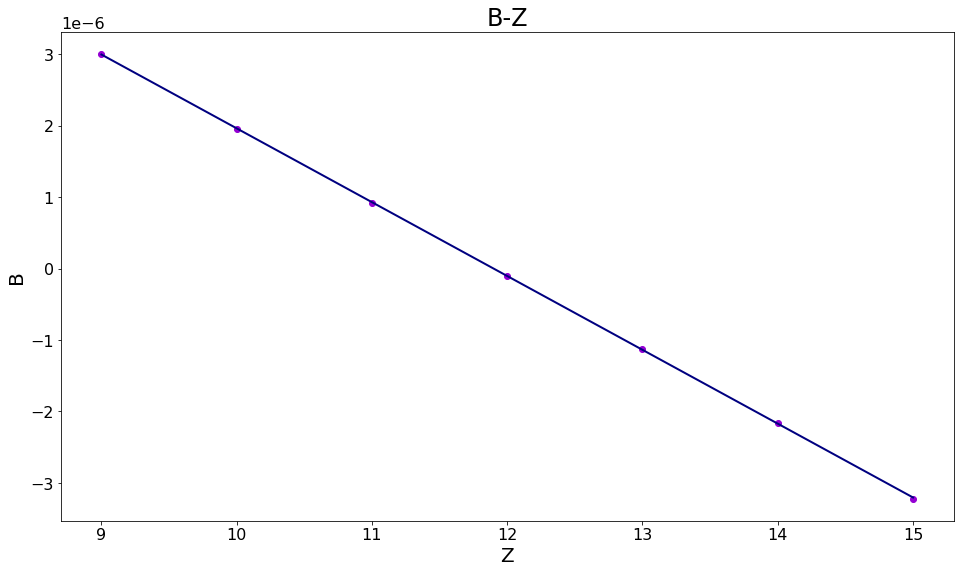

1.0159865962446008e-15

In [12]:
def cal_grad(params):
        l=23.8
        r=0.162/2
        #n=20
        u=4*np.pi*1e-7
        N=1
        I=np.array([1,-1])

        params=np.round(params,decimals=4)
        inv_para=l/100-params[-1::-1]
        z=np.concatenate([params,inv_para])
        print('z is:',z.tolist())
        res=[]
        x=[]
        for s in range(0,int(np.ceil(l))+1):
            s/=100
            x.append(s)
            d=np.square(z-s)
            b=np.sum(I*u*r**2*N/(2*np.power(r**2+d,1.5)))
            res.append(b)
        low=int(np.floor(l/2-2.5))
        up=int(np.ceil(l/2+2.5))
        array=res[low:up+1]
        x_centre=range(low,up+1)
        y=array
        k,b=linear_regre_1d(x_centre,y)
        y_hat=k*x_centre+b
        grad=loss(y,y_hat)
        print('linear area is:',grad)

        plt.figure(figsize=(16,9))
        plt.title('B-Z',fontsize=24)
        plt.xlabel('Z',fontsize=20)
        plt.ylabel('B',fontsize=20)
        plt.scatter(x_centre,array,c='darkviolet')
        plt.plot(x_centre,y_hat,c='navy')
        plt.show()
        return grad

params=np.array([23.8/2-16.2/2])/100
print('params:',params)
cal_grad(params)
    

In [2]:
def cal_grad_2(params):
        l=23.8
        r=0.162/2
        #n=20
        u=4*np.pi*1e-7
        N=1
        
        pos_com=np.array([params[0],l/100-params[0]])
        I_com=np.array([params[1]]*2)
        z=[0.001,0.237,0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0.18420000000000003, 0.14390000000000003,0.2194, 0.2013, 0.23800000000000002, 0.14730000000000001, 0.2078, 0.19190000000000002, 0.136]
        I=np.array([1]*len(z))
        I=np.concatenate([I,I_com])
        z=np.array(z)
        z=np.concatenate([z,pos_com])

        z=np.round(z,decimals=4)
        print('z is:',z.tolist())
        res=[]
        x=[]
        for s in range(0,int(np.ceil(l))+1):
            s/=100
            x.append(s)
            d=np.square(z-s)
            b=np.sum(I*u*r**2*N/(2*np.power(r**2+d,1.5)))
            res.append(b)
        low=int(np.floor(l/2-2.5))
        up=int(np.ceil(l/2+2.5))
        array=res[low:up+1]
        dy=np.max(array)-np.min(array)
        #dx=(index_1-index_2)/100
        grad=dy*7e9
        rel_err=dy/np.mean(array)
        print('grad and rel_err are:',grad,rel_err)

        plt.figure(figsize=(16,9))
        plt.title('B-Z',fontsize=24)
        plt.xlabel('Z',fontsize=20)
        plt.ylabel('B',fontsize=20)
        plt.plot(x,res,c='darkviolet')
        plt.show()
        return grad

43 (trainer)
INFO     params [0.07854557 0.29739658]
z is: [0.001, 0.237, 0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0.1842, 0.1439, 0.2194, 0.2013, 0.238, 0.1473, 0.2078, 0.1919, 0.136, 0.0785, 0.1595]
INFO     cost 0.000869055734958006 +/- 0.0
INFO     Run:944 (trainer)
INFO     params [0.03025044 0.30828796]
z is: [0.001, 0.237, 0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0.1842, 0.1439, 0.2194, 0.2013, 0.238, 0.1473, 0.2078, 0.1919, 0.136, 0.0303, 0.2077]
INFO     cost 0.0034052526225470258 +/- 0.0
INFO     Run:945 (trainer)
INFO     params [0.06043919 0.42808364]
z is: [0.001, 0.237, 0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0.1842, 0.1439, 0.2194, 0.2013, 0.238, 0.1473, 0.2078, 0.1919, 0.136, 0.0604, 0.1776]
INFO     cost 0.0038130005676807388 +/- 0.0
INFO     Run:946 (trainer)
INFO     params [0.04695124 0.36879404]
z is: [0.001, 0.237, 0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0

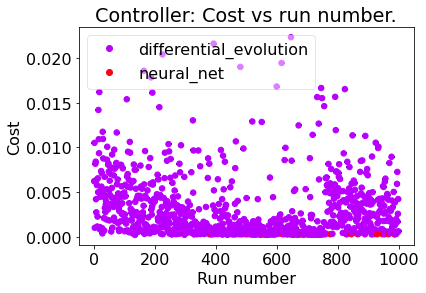

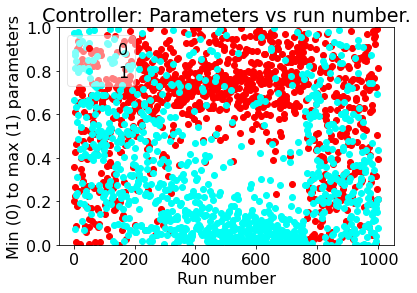

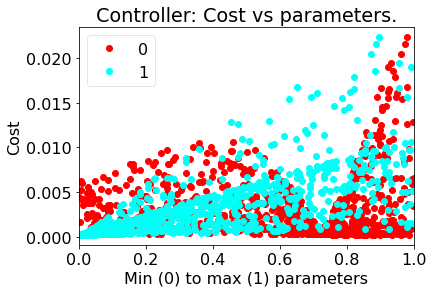

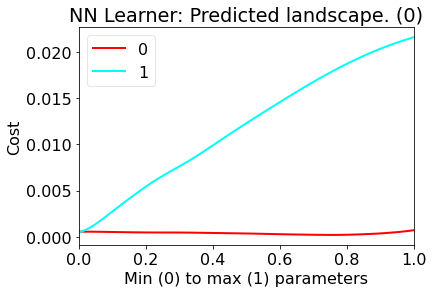

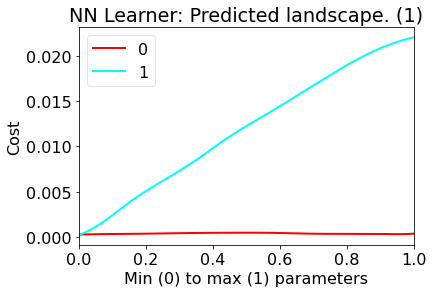

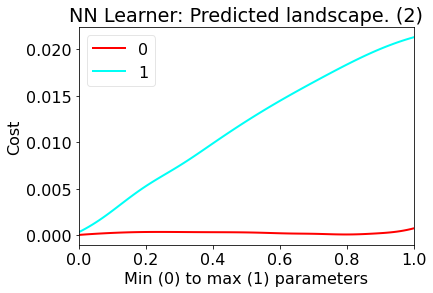

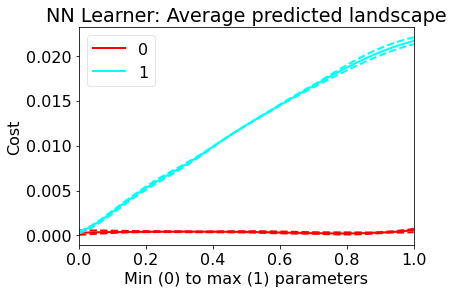

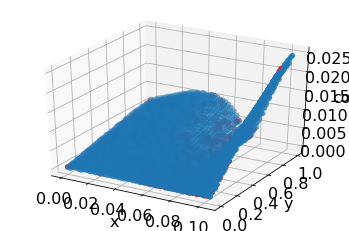

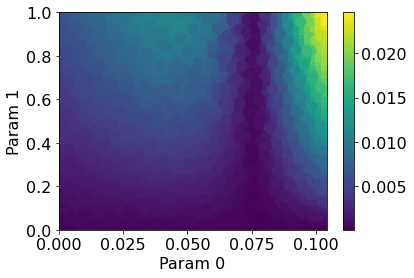

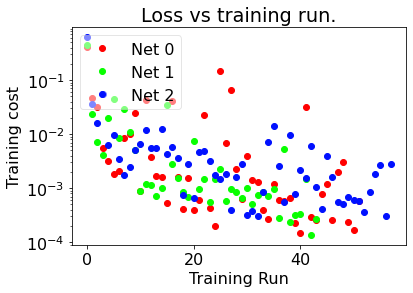

z is: [0.001, 0.237, 0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0.1842, 0.1439, 0.2194, 0.2013, 0.238, 0.1473, 0.2078, 0.1919, 0.136, 0.1, 0.138]
grad and rel_err are: 118.63475335630969 0.00022759904792824404


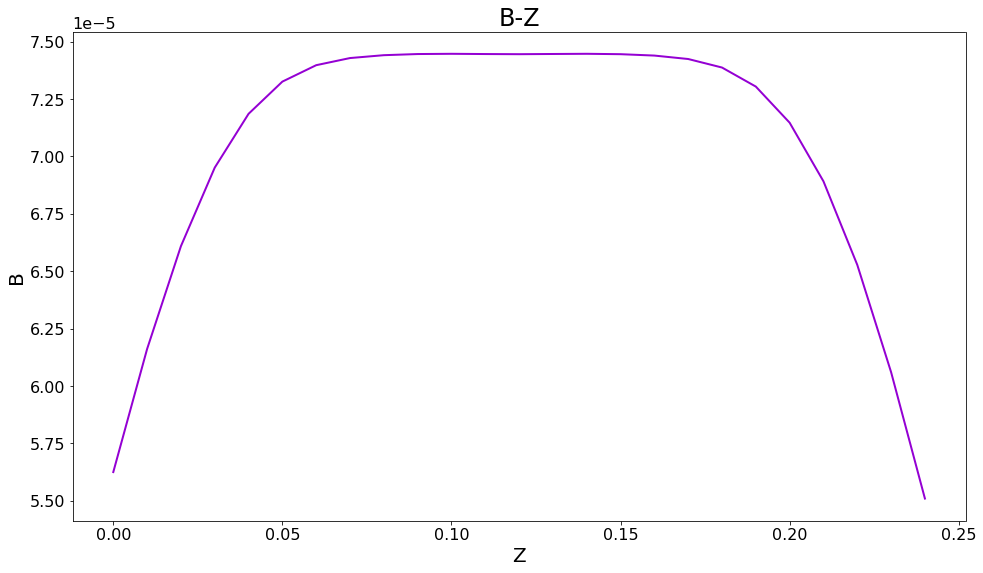

z is: [0.001, 0.237, 0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0.1842, 0.1439, 0.2194, 0.2013, 0.238, 0.1473, 0.2078, 0.1919, 0.136, 0.0784, 0.1596]
grad and rel_err are: 154.98905746219094 0.0002970256480710917


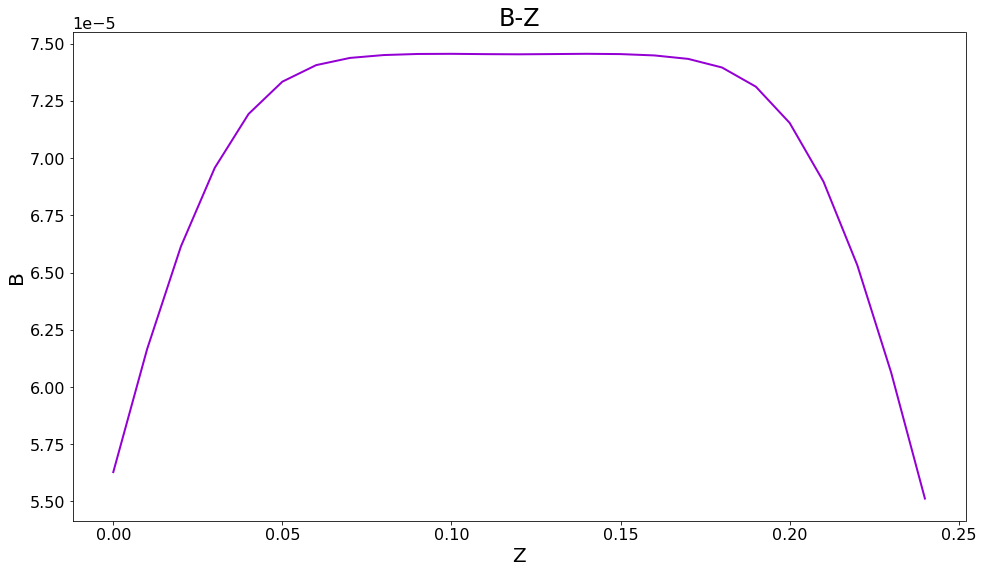

In [3]:
#Declare your custom class that inherets from the Interface class
class CustomInterface_2(mli.Interface):
    
    #Initialization of the interface, including this method is optional
    def __init__(self):
        #You must include the super command to call the parent class, Interface, constructor 
        super(CustomInterface_2,self).__init__()
        self.l=23.8
        self.r=0.162/2
        
    
    def get_next_cost_dict(self,params_dict):
        
        #Get parameters from the provided dictionary
        params = params_dict['params']
        
        cost=self.cal_grad(params=params)

        uncer = 0
        #The evaluation will always be a success
        if cost<0:
            bad=True
        else:
            bad = False
        
        cost_dict = {'cost':cost, 'uncer':uncer, 'bad':bad}
        return cost_dict

    def cal_grad(self,params):
        l=23.8
        r=0.162/2
        #n=20
        u=4*np.pi*1e-7
        N=1
        
        pos_com=np.array([params[0],l/100-params[0]])
        I_com=np.array([params[1]]*2)
        z=[0.001,0.237,0.102, 0.0461, 0.0, 0.0302, 0.0907, 0.0367, 0.0186, 0.0941, 0.0538, 0.18420000000000003, 0.14390000000000003,0.2194, 0.2013, 0.23800000000000002, 0.14730000000000001, 0.2078, 0.19190000000000002, 0.136]
        I=np.array([1]*len(z))
        I=np.concatenate([I,I_com])
        z=np.array(z)
        z=np.concatenate([z,pos_com])

        z=np.round(z,decimals=4)
        print('z is:',z.tolist())
        res=[]
        x=[]
        for s in range(0,int(np.ceil(l))+1):
            s/=100
            x.append(s)
            d=np.square(z-s)
            b=np.sum(I*u*r**2*N/(2*np.power(r**2+d,1.5)))
            res.append(b)
        low=int(np.floor(l/2-2.5))
        up=int(np.ceil(l/2+2.5))
        array=res[low:up+1]
        self.B=np.mean(array)
        return (np.max(array)-np.min(array))/np.mean(array)



def main_2():
    #M-LOOP can be run with three commands
    
    #First create your interface
    interface = CustomInterface_2()
    #Next create the controller. Provide it with your interface and any options you want to set
    n=2
    '''
    para=np.linspace(0,0.135,n+1)
    low=para[0:n]
    up=para[1:n+1]
    '''
    low=[0,0]
    up=[interface.l/200-0.015,1]
    controller = mlc.create_controller(interface, 
                                       #training_type='random',
                                       controller_type='neural_net',
                                       max_num_runs = 1000,
                                       target_cost = 0,
                                       num_params = n, 
                                       min_boundary = low,
                                       max_boundary = up,
                                       keep_prob=0.9)
    #To run M-LOOP and find the optimal parameters just use the controller method optimize
    controller.optimize()
    
    #The results of the optimization will be saved to files and can also be accessed as attributes of the controller.
    print('Best parameters found:')
    print(controller.best_params)
    
    #You can also run the default sets of visualizations for the controller with one command
    mlv.show_all_default_visualizations(controller)
    '''
    mlv.create_neural_net_learner_visualizations(controller.ml_learner.total_archive_filename, 
                                                file_type=controller.ml_learner.learner_archive_file_type,
                                                plot_cross_sections=True)
    
    #plt.show()
    '''

    cal_grad_2(controller.best_params)
    cal_grad_2(controller.predicted_best_parameters)

main_2()

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt

def cal_grad(params):
        l=40
        r=0.15/2
        #r=0.129/2
        #n=np.array([94,44,24,42,42,24,44,94])
        u=4*np.pi*1e-7
        #N=np.array([42,24,44,94,94,44,24,42])
        N=1
        I=0.2

        #params=np.round(params,decimals=4)
        inv_para=l/100-params[-1::-1]
        z=np.concatenate([params,inv_para])
        print('z is:',z.tolist())
        res=[]
        x=[]
        for s in range(0,l+1):
            s/=100
            x.append(s)
            d=np.square(z-s)
            b=np.sum(u*r**2*N/(2*np.power(r**2+d,1.5)))*I
            res.append(b)
        low=int(l/2)-3
        up=low+6
        array=res[low:up+1]
        dy=np.max(array)-np.min(array)
        #dx=(index_1-index_2)/100
        grad=np.std(array)/np.mean(array)
        rel_err=(np.max(array)-np.min(array))/np.mean(array)
        #print('grad and rel_err are:',grad,rel_err)
        #plt.figure(figsize=(16,9))
        plt.title('B-Z',fontsize=24)
        plt.xlabel('Z',fontsize=20)
        plt.ylabel('B',fontsize=20)
        plt.plot(x,res,c='darkviolet')
        plt.show()
        return grad

n is: [0 1 2 3]
z is: [0.184, 0.152, 0.12, 0.088, 0.31200000000000006, 0.28, 0.24800000000000003, 0.21600000000000003]
grad and rel_err are: 0.006182848758886784 0.01602108197275622


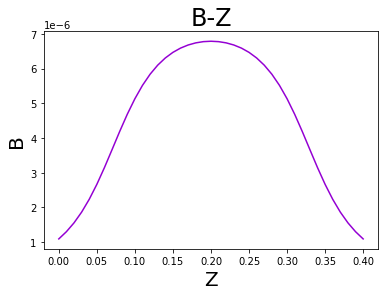

0.006182848758886784

In [10]:
#params=np.array([1.39,1.97,3.95,6.0,6.96,8.22,10.22,11.23,12.84,14.26])/100
n=np.arange(0,4)
print('n is:',n)
params=(20-(1.6+3.2*n))/100
cal_grad(params)

In [3]:
import pandas as pd

In [12]:
filename='G:/data/20200911/25.xlsx'
df = pd.read_excel(filename)
np.abs(df.values.T[0])

array([1.73021 , 1.730332, 1.730278, ..., 1.730333, 1.730348, 1.730319])

In [10]:
x=np.arange(12,37.5,0.5)
x_list=x.tolist()
x

array([12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5,
       23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. ,
       28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5,
       34. , 34.5, 35. , 35.5, 36. , 36.5, 37. ])

grad and rel_err are: 0.0022081401702826113 0.006194357524245556
z is: [0.0139, 0.0197, 0.0395, 0.06, 0.0696, 0.08220000000000001, 0.10220000000000001, 0.11230000000000001, 0.1284, 0.1426, 0.15739999999999998, 0.1716, 0.18769999999999998, 0.19779999999999998, 0.2178, 0.2304, 0.24, 0.2605, 0.2803, 0.28609999999999997]
grad and rel_err are: 2.2278406108154496e-05 6.604088568612436e-05


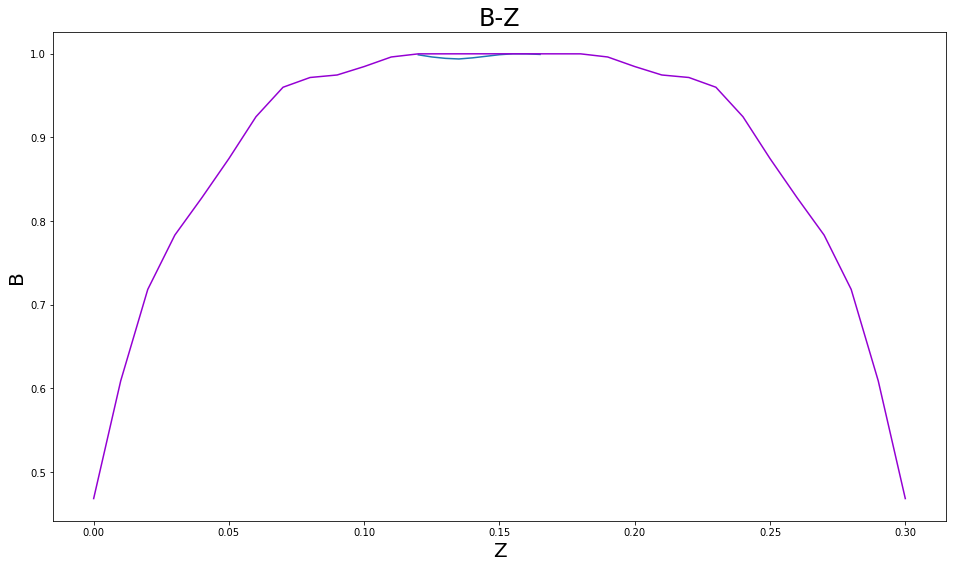

2.2278406108154496e-05

In [10]:
a,b=22,27
x=np.arange(a,b,0.5)
x_list=x.tolist()
y = []
variance = []
for i in x_list:
    if 15<=i<=30: 
        minus=True
    else:
        minus=False
    i = str(i)
    if i[-1] == '0': i=i[0:len(i)-2]
    filename='D:/data/20200911/'+i+'.xlsx'
    df=pd.read_excel(filename)
    df = np.abs(df.values.T[0])
    if minus:
        fileminus='D:/data/20200914/'+i+'.xlsx'
        df_minus=pd.read_excel(fileminus)
        df_minus=np.abs(df_minus.values.T[0])
        df_minus_mean=df_minus.mean()
    else:
        df_minus_mean=0
    data_mean = df.mean()-df_minus_mean
    data_std = df.std()/np.sqrt(len(df))
    y.append(data_mean)
    variance.append(data_std)
plt.figure(figsize=(16,9))
array = y
grad = np.std(array)/np.mean(array)
rel_err = (np.max(array)-np.min(array))/np.mean(array)
x=(x-10)/100
plt.plot(x,y/np.max(y))
print('grad and rel_err are:',grad,rel_err)
params=np.array([1.39,1.97,3.95,6.0,6.96,8.22,10.22,11.23,12.84,14.26])/100
cal_grad(params)